# Lecture 4: Activation, Gradients and Batch Normalization

In this lecture, we will dive deeper into activation functions and gradients. We will also introduce batch normalization.

## Complex architectures

In the previous lectures, we have seen how to build a single layer, and a multi-layer neural network. In practice, we often use more complex architectures, such as convolutional neural network (CNN), or a recurrent neural network (RNN).
- MLP: [wikipedia](https://en.wikipedia.org/wiki/Multilayer_perceptron)
- CNN: [LeCun et al. 1989](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)
- RNN: [Sutskever et al. 2011](https://arxiv.org/pdf/1409.3215)

In order to proceed to those more complex architectures, we need to dive deeper into **activation functions** and **gradients**.

## MLP

Let's continue with our MLP model.

### Importing libraries

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass
from src.utils import load_text, set_seed, configure_device

### Configuration

In [2]:
@dataclass
class MLPConfig:
    root_dir: str = os.getcwd() + "/../../"
    dataset_path: str = "data/names.txt"
    device: torch.device = torch.device('cpu')  # Automatic device configuration

    # Tokenizer
    vocab_size: int = 0  # Set later
    
    # Model
    context_size: int = 3
    d_embed: int = 16
    d_hidden: int = 256
    
    # Training
    val_size: float = 0.1
    val_interval: int = 100
    batch_size: int = 32
    lr: float = 0.01
    max_steps: int = 1000

    seed: int = 101

### Reproducibility

In [3]:
set_seed(MLPConfig.seed)
generator = torch.Generator().manual_seed(MLPConfig.seed)

Random seed set to 101


### Device

In [4]:
#MLPConfig.device = configure_device()

### Dataset

In [5]:
# Load text and split by lines
names = load_text(MLPConfig.root_dir + MLPConfig.dataset_path).splitlines()

Loaded text data from /mnt/c/Users/cheir/GitHub/LLM101/notebooks/Lectures/../../data/names.txt (length: 228145 characters).


### Tokenizer

In [6]:
chars = [chr(i) for i in range(97, 123)]  # all alphabet characters
chars.insert(0, ".")  # Add special token
MLPConfig.vocab_size = len(chars)
str2idx = {char: idx for idx, char in enumerate(chars)}
idx2str = {idx: char for char, idx in str2idx.items()}

### Preprocessing

#### Train-validation split

In [7]:
def split_names(_names, val_size):
    if val_size <= 0 or val_size >= 1:
        raise ValueError(f"Invalid validation size: {val_size}")
    ################################################################################
    # TODO:                                                                        #
    # Split the data into training and validation sets.                            #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    split_idx = int(len(_names) * (1 - val_size))
    train_text, val_text = _names[:split_idx], _names[split_idx:]
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return train_text, val_text

In [8]:
train_names, val_names = split_names(names, MLPConfig.val_size)

#### Dataloader

In [9]:
def dataloader(_names):
    _inputs, _targets = [], []

    for name in names:
        _context = [0] * MLPConfig.context_size
        
        for char in name + ".":
            idx = str2idx[char]
            _inputs.append(_context)
            _targets.append(idx)
            _context = _context[1:] + [idx]  # Shift the context by 1 character

    _inputs = torch.tensor(_inputs)
    _targets = torch.tensor(_targets)
    
    return _inputs, _targets

inputs, targets = dataloader(names)

In [10]:
train_inputs, train_targets = dataloader(train_names)
val_inputs, val_targets = dataloader(val_names)

In [11]:
# Check the shapes
print(f"Training inputs shape: {train_inputs.shape}")
print(f"Training targets shape: {train_targets.shape}")
print(f"Validation inputs shape: {val_inputs.shape}")
print(f"Validation targets shape: {val_targets.shape}")

Training inputs shape: torch.Size([228146, 3])
Training targets shape: torch.Size([228146])
Validation inputs shape: torch.Size([228146, 3])
Validation targets shape: torch.Size([228146])


### Model

In [12]:
class MLP(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden))
        self.b1 = nn.Parameter(torch.randn(d_hidden))
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size))
        self.b2 = nn.Parameter(torch.randn(vocab_size))
        
    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)
        
        # Hidden layer
        h = F.tanh(x @ self.W1 + self.b1)  # (batch_size, d_hidden)
        
        # Output layer
        logits = torch.matmul(h, self.W2) + self.b2  # (batch_size, vocab_size)
        return logits

In [13]:
# Initialize the model
mlp = MLP(MLPConfig.vocab_size, MLPConfig.context_size, MLPConfig.d_embed, MLPConfig.d_hidden)
mlp.to(MLPConfig.device) # Move the model to the device
print(mlp)
print("Number of parameters:", sum(p.numel() for p in mlp.parameters()))

MLP()
Number of parameters: 19915


### Training

In [14]:
def train(model, max_steps=MLPConfig.max_steps):
    steps = []
    train_losses = []
    val_losses = []
    
    # Define the optimizer
    ################################################################################
    # TODO:                                                                        #
    # Define the optimizer for the model.                                          #
    # Use stochastic gradient descent (SGD) with the learning rate from the config.#
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    optimizer = torch.optim.SGD(mlp.parameters(), lr=MLPConfig.lr)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    for step in range(1, max_steps + 1):
        # Training
        # Sample batch
        idx = torch.randperm(len(train_inputs))[:MLPConfig.batch_size]
        x, y = train_inputs[idx], train_targets[idx]
        x, y = x.to(MLPConfig.device), y.to(MLPConfig.device)  # Move the data to the device
        
        ################################################################################
        # TODO:                                                                        #
        # Implement the forward pass and the backward pass                             #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Forward pass
        optimizer.zero_grad()
        logits = model(x)
        # print(logits[0])
        loss = F.cross_entropy(logits, y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # Validation
        if step % MLPConfig.val_interval == 0:
            # Validation loss
            with torch.no_grad():
                val_logits = model(val_inputs.to(MLPConfig.device))
                val_loss = F.cross_entropy(val_logits, val_targets.to(MLPConfig.device)).item()
                val_losses.append(val_loss)
            
        # Logging
        steps.append(step)
        train_losses.append(loss.item())
        if step == 1:
            print(f"Initial Train Loss = {loss.item():.4f}")
        if step % MLPConfig.val_interval == 0:
            print(f"Step {step}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss:.4f}")
    
    final_val_logits = model(val_inputs.to(MLPConfig.device))
    final_val_loss = F.cross_entropy(final_val_logits, val_targets.to(MLPConfig.device)).item()
    print(f"Final Validation Loss = {final_val_loss:.4f}")

    # Plot the loss
    if max_steps > MLPConfig.val_interval:
        plt.figure()
        plt.plot(steps, train_losses, label="Train")
        plt.plot(steps[::MLPConfig.val_interval], val_losses, label="Validation")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

Initial Train Loss = 33.2388
Step 100: Train Loss = 23.2899, Val Loss = 20.1987
Step 200: Train Loss = 14.8778, Val Loss = 16.7986
Step 300: Train Loss = 15.3965, Val Loss = 14.7098
Step 400: Train Loss = 11.1974, Val Loss = 13.2735
Step 500: Train Loss = 12.3092, Val Loss = 12.2508
Step 600: Train Loss = 10.1758, Val Loss = 11.4825
Step 700: Train Loss = 9.9928, Val Loss = 10.8868
Step 800: Train Loss = 11.8601, Val Loss = 10.4136
Step 900: Train Loss = 9.1617, Val Loss = 9.9559
Step 1000: Train Loss = 9.5113, Val Loss = 9.5974
Final Validation Loss = 9.5974


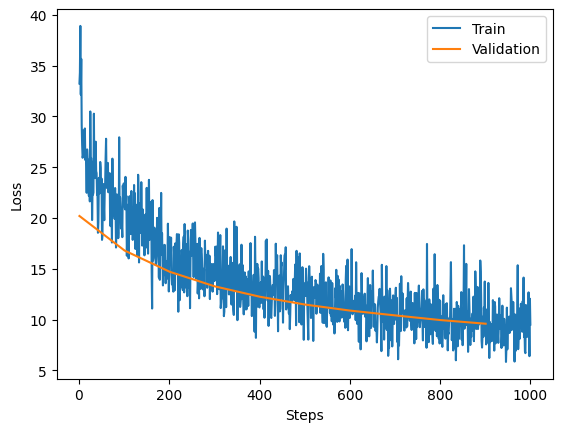

In [15]:
train(model=mlp, max_steps=MLPConfig.max_steps)

#### Problem 1: Initialization

Q: What is the initial loss value? What can you discuss about the loss value?

In [16]:
################################################################################
# TODO:                                                                        #
# Before the model is trained,                                                 #
# we expect the model to predict a uniform distribution over the classes       #
# What should be the initial loss value for a uniform distribution?            #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
prob_char = 1 / 27  # 1 / vocab_size
initial_loss = -torch.log(torch.tensor(prob_char)).item()
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
print(f"Initial loss value: {initial_loss:.4f}")

Initial loss value: 3.2958


In [17]:
# Example of wrong initialization issue
# Goal: Predict the correct class out of 4 classes
#example_logits = torch.tensor([0, 0, 0, 0], dtype=torch.float32)  # Uniform distribution
exemple_logits = torch.randn(4) * 1000
target = 0
prob = F.softmax(exemple_logits, dim=-1)
loss = -prob[target].log()

print(f"Example logits: {exemple_logits}")
print(f"Example probabilities: {prob}")
print(f"Example loss value: {loss:.4f}")

Example logits: tensor([-1818.5339,  1412.3542, -1033.5936,  -178.6658])
Example probabilities: tensor([0., 1., 0., 0.])
Example loss value: inf


In [18]:
# Solution: Re-initialize the model
# Make the logits smaller
class MLP2(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden))
        self.b1 = nn.Parameter(torch.randn(d_hidden))
        ################################################################################
        # TODO:                                                                        #
        # Re-initialize the model with a small value to get low logits                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size) * 0.1)  # Initialize with a small value
        self.b2 = nn.Parameter(torch.randn(vocab_size) * 0.01)           # Initialize with a small value
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)
        
        # Hidden layer
        h = F.tanh(x @ self.W1 + self.b1)  # (batch_size, d_hidden)
        
        # Output layer
        logits = torch.matmul(h, self.W2) + self.b2  # (batch_size, vocab_size)
        return logits

In [19]:
# Initialize the MLP V2
mlp2 = MLP2(MLPConfig.vocab_size, MLPConfig.context_size, MLPConfig.d_embed, MLPConfig.d_hidden)
mlp2.to(MLPConfig.device) # Move the model to the device
print(mlp2)
print("Number of parameters:", sum(p.numel() for p in mlp2.parameters()))

MLP2()
Number of parameters: 19915


Initial Train Loss = 3.9915
Step 100: Train Loss = 4.2777, Val Loss = 4.2395
Step 200: Train Loss = 4.0824, Val Loss = 4.2395
Step 300: Train Loss = 4.2179, Val Loss = 4.2395
Step 400: Train Loss = 3.8880, Val Loss = 4.2395
Step 500: Train Loss = 4.0623, Val Loss = 4.2395
Step 600: Train Loss = 3.7695, Val Loss = 4.2395
Step 700: Train Loss = 4.7770, Val Loss = 4.2395
Step 800: Train Loss = 4.4815, Val Loss = 4.2395
Step 900: Train Loss = 3.9086, Val Loss = 4.2395
Step 1000: Train Loss = 4.0575, Val Loss = 4.2395
Final Validation Loss = 4.2395


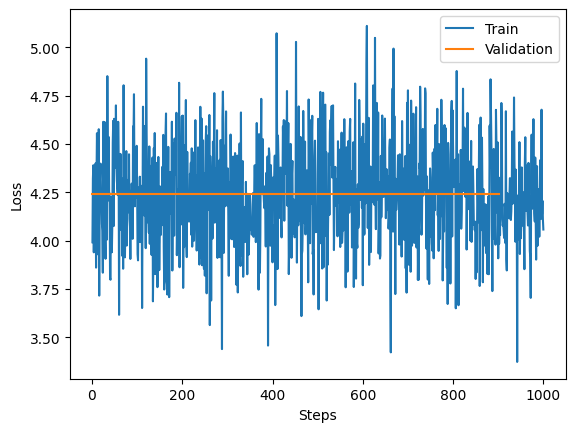

In [20]:
# Train the model
# train(model=mlp2, max_steps=1)
train(model=mlp2, max_steps=MLPConfig.max_steps)

Initialization problem solved!

Remember, initialization is a crucial step in training neural networks. If the weights are initialized with large values, the model may not converge. 

#### Problem 2: Activation functions

Q: What is the activation function used in the hidden layer? What is the 
characteristic of this activation function?

[PyTorch Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html)

In [21]:
# Forward pass
_idx = torch.randperm(len(train_inputs))[:MLPConfig.batch_size]
_x = train_inputs[_idx]
_x_embed = mlp2.C[_x]
_x = _x_embed.view(_x.size(0), -1)
_x = _x @ mlp2.W1 + mlp2.b1
h = F.tanh(_x)

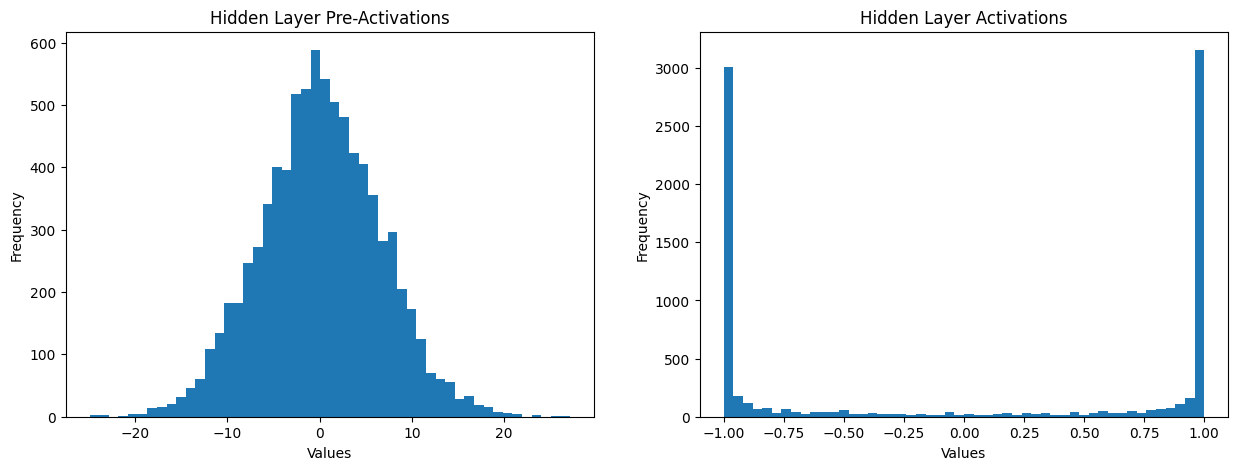

In [22]:
# Plot the histogram of the hidden layer pre-activations and activations
plt.figure(figsize=(15, 5))
# Pre-activations
plt.subplot(1, 2, 1)
plt.hist(_x.view(-1).tolist(), bins=50)
plt.title("Hidden Layer Pre-Activations")
plt.xlabel("Values")
plt.ylabel("Frequency")
# Activations
plt.subplot(1, 2, 2)
plt.hist(h.view(-1).tolist(), bins=50, range=(-1, 1))
plt.title("Hidden Layer Activations")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

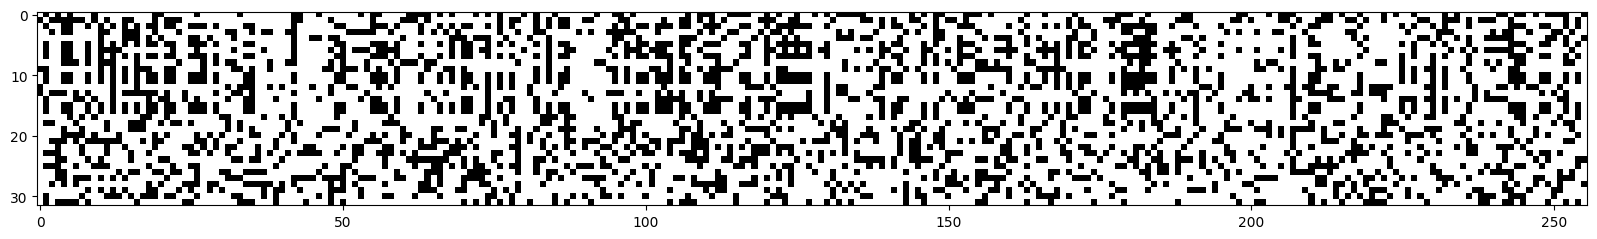

In [23]:
plt.figure(figsize=(20, 10))
# White if the value is larger than 0.99
# Black if the value is smaller than 0.99
plt.imshow(h.abs().cpu().detach().numpy() > 0.99, cmap="gray", interpolation="nearest")
# If there is a column with all white, it means that the model will never learn -> Dead Neurons

In [24]:
################################################################################
# TODO:                                                                        #
# Explain the problem with the graph above.                                    #
# Hint: Lecture 1, custom tensor auto-grad engine.                             #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

Adding more layers and making the model deeper is known to have better generalization performance.

The reason why people didn't add more layers in the past was because of the vanishing gradient problem.

In [25]:
# Solution1: Re-re-initialize the model
# Make the pre-activations smaller
class MLP3(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Re-initialize the model with a small value                                   #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed) * 0.5)                # Initialize with a small value
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden) * 0.2)  # Initialize with a small value
        self.b1 = nn.Parameter(torch.randn(d_hidden) * 0.1)                          # Initialize with a small value
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size) * 0.1)              # Initialize with a small value
        self.b2 = nn.Parameter(torch.randn(vocab_size) * 0.01)                       # Initialize with a small value
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)
        
        # Hidden layer
        h = F.tanh(x @ self.W1 + self.b1)  # (batch_size, d_hidden)
        
        # Output layer
        logits = torch.matmul(h, self.W2) + self.b2  # (batch_size, vocab_size)
        return logits

In [26]:
# Initialize the MLP V3
mlp3 = MLP3(MLPConfig.vocab_size, MLPConfig.context_size, MLPConfig.d_embed, MLPConfig.d_hidden)
mlp3.to(MLPConfig.device) # Move the model to the device
print(mlp3)
print("Number of parameters:", sum(p.numel() for p in mlp3.parameters()))

MLP3()
Number of parameters: 19915


In [27]:
# Forward pass
_idx = torch.randperm(len(train_inputs))[:MLPConfig.batch_size]
_x = train_inputs[_idx]
_x_embed = mlp3.C[_x]
_x = _x_embed.view(_x.size(0), -1)
_x = _x @ mlp3.W1 + mlp3.b1
h = F.tanh(_x)

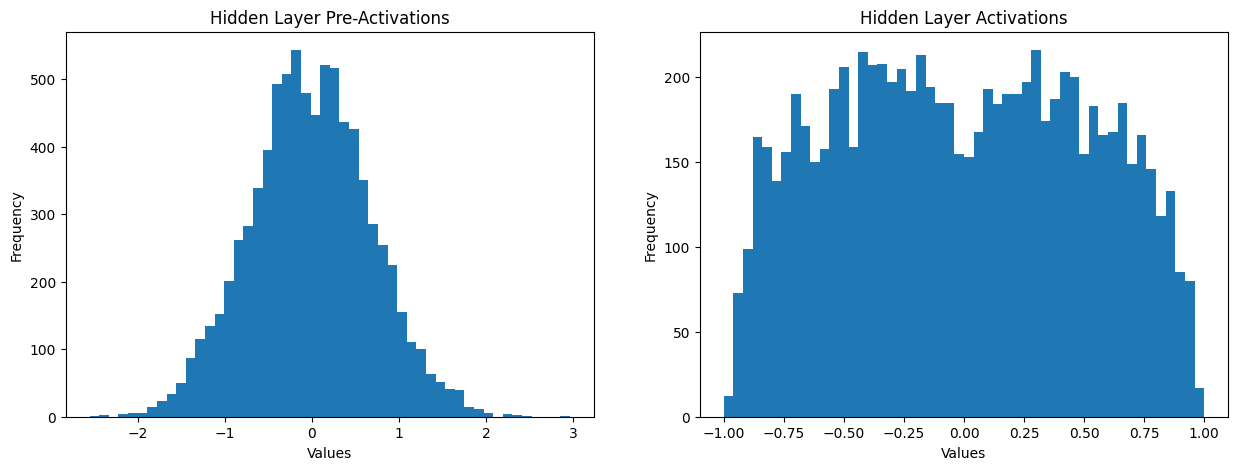

In [28]:
# Plot the histogram of the hidden layer pre-activations and activations
plt.figure(figsize=(15, 5))
# Pre-activations
plt.subplot(1, 2, 1)
plt.hist(_x.view(-1).tolist(), bins=50)
plt.title("Hidden Layer Pre-Activations")
plt.xlabel("Values")
plt.ylabel("Frequency")
# Activations
plt.subplot(1, 2, 2)
plt.hist(h.view(-1).tolist(), bins=50, range=(-1, 1))
plt.title("Hidden Layer Activations")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

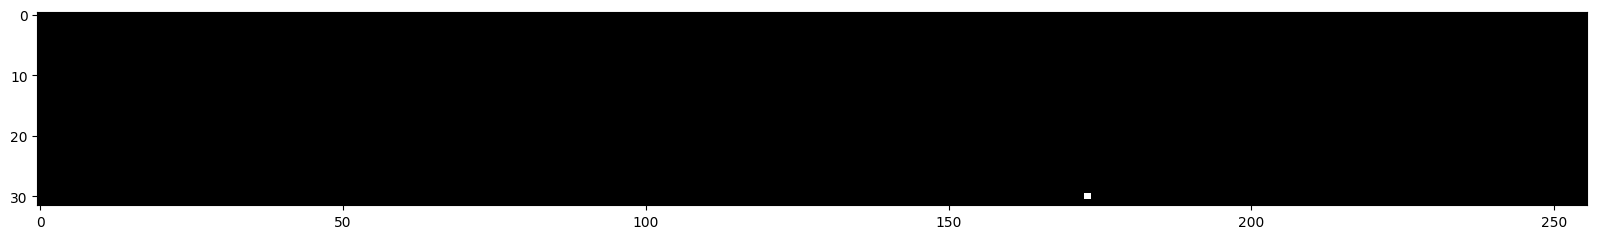

In [29]:
plt.figure(figsize=(20, 10))
# White if the value is larger than 0.99
# Black if the value is smaller than 0.99
plt.imshow(h.abs().cpu().detach().numpy() > 0.99, cmap="gray", interpolation="nearest")
# If there is a column with all white, it means that the model will never learn -> Dead Neurons

Initial Train Loss = 3.5584
Step 100: Train Loss = 3.8010, Val Loss = 3.6452
Step 200: Train Loss = 3.6319, Val Loss = 3.6452
Step 300: Train Loss = 3.6757, Val Loss = 3.6452
Step 400: Train Loss = 3.6380, Val Loss = 3.6452
Step 500: Train Loss = 3.6024, Val Loss = 3.6452
Step 600: Train Loss = 3.8217, Val Loss = 3.6452
Step 700: Train Loss = 3.4867, Val Loss = 3.6452
Step 800: Train Loss = 3.4266, Val Loss = 3.6452
Step 900: Train Loss = 3.7333, Val Loss = 3.6452
Step 1000: Train Loss = 3.5965, Val Loss = 3.6452
Final Validation Loss = 3.6452


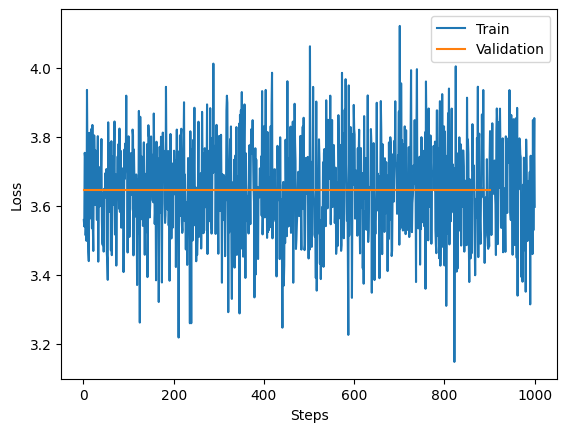

In [30]:
# Train the model
train(model=mlp3, max_steps=MLPConfig.max_steps)